In [1]:
# Done by Ignacio Cuevas Ruiz & Juan Valentín Guerrero Cano



import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression as MI
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score

from scipy import stats

# Preprocessing

In [2]:
# Use pandas t o l o a d i n t o a DataFrame
# Y1 . c s v doesn ’ t have a he ade r s o
# add one when l o a di n g the f i l e
X1 = pd.read_csv('X1.csv')
Y1 = pd.read_csv('Y1.csv', header=None , names =['revenue'])

#                     DROP FEATURES
#Delete the features which are strings and which does not give much information
X1_aux = X1.drop(['title', 'img_url', 'description'], axis=1) 
#We also have to drop the feature "Unnamed: 0" cause it is not a real feature, is due to the original database of the dataframe
X1_aux = X1_aux.drop('Unnamed: 0', axis=1)
#Also the feature 'is_adult' should be deleted as its unique value is 0.
X1_aux=X1_aux.drop('is_adult',axis=1)


#                    RUNTIME
#Just to reformat the NaN of the "runtime" column and change it by its mean
X1_aux.runtime = X1_aux.runtime.replace({"\\N": np.nan})
X1_aux['runtime']=X1_aux['runtime'].astype('float64')
runtime_Mean=X1_aux['runtime'].mean()
X1_aux.runtime=X1_aux.runtime.replace({np.nan:runtime_Mean})

#                     GENRES
#Now we will split the feature "genres". To do this first we will take all the possible genres and then apply 
# "One hot enconding"
dataframe = X1_aux.genres.str.split(",",expand= True)
lista1 = dataframe[0].unique()
lista2 = dataframe[1].unique()
lista3 = dataframe[2].unique()
lista_aux = np.append(lista1, lista2)
set_genres = set(np.append(lista_aux,lista3))
set_genres.remove(None)
lista_genres = list(set_genres)
for i in range(len(lista_genres)):
    X1_aux.insert(6+i,lista_genres[i],0)

X1_aux = X1_aux.drop('genres', axis=1)

for i in range(3540):
    for j in range(len(lista_genres)):
        for z in range(3):
            if lista_genres[j] == dataframe.iloc[i][z]:
                X1_aux.loc[i,lista_genres[j]] = 1

#                EMBEDDINGS
#We split the feature "img_embeddings"  
df_img = X1_aux.img_embeddings.str[1:-1].str.split(",",expand= True)
col_names=[]
for i in range(len(df_img.columns)):
    col_names = col_names + [f'img_{i}']
df_img.columns=col_names
df_img = df_img.astype('float64')

#We do the same with the feature "text_embeddings"
df_txt = X1_aux.text_embeddings.str[1:-1].str.split(",",expand= True)
col_names=[]
for i in range(len(df_txt.columns)):
    col_names = col_names + [f'txt_{i}']
df_txt.columns=col_names
df_txt = df_txt.astype('float64')


#               STUDIO
#Transform Categorical feature "studio" into numerical feature
le = preprocessing.LabelEncoder()
le.fit(X1_aux["studio"])
X1_aux["studio"] = le.transform(X1_aux["studio"])


#               REVENUE
#We insert as first feature the target one. This allows us later to get information of each feature with the target
X1_aux.insert(0, 'Revenue', 0 )
X1_aux['Revenue'] = Y1['revenue']

X1_aux = X1_aux.drop('\\N', axis=1)

In [3]:
X1_aux

,Revenue,ratings,n_votes,production_year,runtime,release_year,Musical,Family,Thriller,Fantasy,...,Action,Horror,Film-Noir,Biography,Drama,Comedy,Documentary,studio,img_embeddings,text_embeddings
0,7.158530e+07,6.5,92937.0,2010,105.000000,2010.0,0,0,0,0,...,0,0,0,0,1,1,0,431,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934..."
1,8.964834e+04,7.9,11.0,1996,92.293346,2014.0,0,0,0,0,...,1,0,0,0,1,0,0,476,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722..."
2,3.164907e+07,5.9,1345.0,1978,127.000000,1978.0,0,1,0,0,...,0,0,0,0,1,0,0,274,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415..."
3,3.898197e+07,6.6,4851.0,1994,105.000000,1994.0,0,0,0,0,...,0,0,0,1,1,0,0,310,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693..."
4,9.697023e+06,4.1,549.0,1982,108.000000,1982.0,0,0,0,0,...,0,0,0,0,1,0,0,274,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,1.280834e+05,6.3,973.0,1997,94.000000,1999.0,0,0,0,0,...,0,0,0,0,0,1,0,118,"[0.19991912, 1.3718543, 1.1531808, 0.052152418...","[-0.55224955, 0.26953417, 0.99950045, -0.98031..."
3536,5.620866e+04,8.0,2190.0,1961,25.000000,2017.0,0,0,0,1,...,0,1,0,0,1,0,0,89,"[0.38660493, 0.81947947, 1.9521054, 0.23831718...","[-0.52293366, 0.35181606, 0.9992165, -0.974448..."
3537,2.677043e+06,7.6,34.0,2001,44.000000,2000.0,0,0,0,0,...,0,0,0,0,1,0,0,393,"[0.15014637, 2.0139444, 1.0844889, 0.17270318,...","[-0.61463475, 0.4013893, 0.99981415, -0.985390..."
3538,4.480911e+05,7.5,27379.0,2006,98.000000,2006.0,0,0,0,0,...,0,0,0,0,0,0,1,211,"[0.25391683, 3.8994913, 0.23327282, 0.17322594...","[-0.74685824, 0.43955636, 0.99979496, -0.98784..."


# Applying PCA 

Shape of txt componentes before PCA:  (3540, 768)
Shape of txt componentes after PCA:  (3540, 8)
Shape of img  componentes before PCA:  (3540, 2048)
Shape of img componentes after PCA:  (3540, 406)


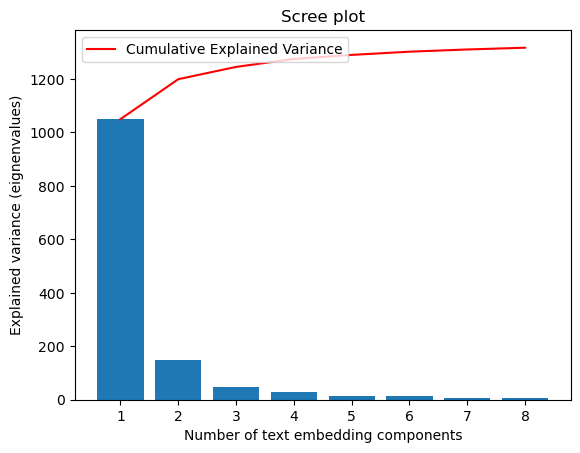

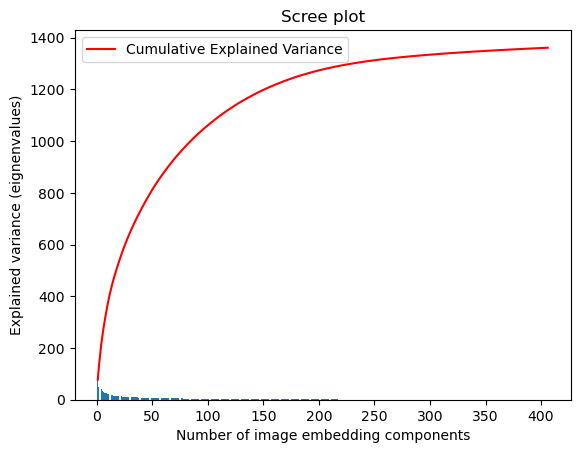

In [4]:
#PCA is effected by scale so you need to scale the features in the data before applying PCA
txt_scaler  = RobustScaler()

img_scaler = RobustScaler()

df_txt_scaled = txt_scaler.fit_transform(df_txt.to_numpy())
df_txt_scaled = pd.DataFrame(df_txt_scaled,columns= df_txt.columns.values )

df_img_scaled = img_scaler.fit_transform(df_img.to_numpy())
df_img_scaled = pd.DataFrame(df_img_scaled,columns= df_img.columns.values )

pca_txt = PCA(0.95)
pca_img = PCA(0.95)

reduced_features_txt = pca_txt.fit_transform(df_txt_scaled)
reduced_features_img = pca_img.fit_transform(df_img_scaled)

print('Shape of txt componentes before PCA: ', df_txt.shape)
print('Shape of txt componentes after PCA: ', reduced_features_txt.shape)  

print('Shape of img  componentes before PCA: ', df_img.shape)
print('Shape of img componentes after PCA: ', reduced_features_img.shape)  


plt.bar(
    range(1,len(pca_txt.explained_variance_)+1),
    pca_txt.explained_variance_
    )
 
plt.plot(
    range(1,len(pca_txt.explained_variance_ )+1),
    np.cumsum(pca_txt.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of text embedding components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')
 
plt.show()

plt.bar(
    range(1,len(pca_img.explained_variance_)+1),
    pca_img.explained_variance_
    )
 
plt.plot(
    range(1,len(pca_img.explained_variance_ )+1),
    np.cumsum(pca_img.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of image embedding components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')

plt.show()


In [5]:
#We compute a dataframe with the reduced features and concatenate them to the X1_aux
pca_txt_columns = []
pca_img_columns =[]
pca_txt_columns = pca_txt_columns + ['pca_txt_comp_%i' % i for i in range(reduced_features_txt.shape[1])]
pca_img_columns = pca_img_columns + ['pca_img_comp_%i' % i for i in range(reduced_features_img.shape[1])]


df_txt_pca = pd.DataFrame(reduced_features_txt, columns = pca_txt_columns)
df_img_pca = pd.DataFrame(reduced_features_img, columns = pca_img_columns)

X1_aux = pd.concat([X1_aux, df_txt_pca], axis=1)
X1_aux = pd.concat([X1_aux, df_img_pca], axis=1)
X1_aux = X1_aux.drop(['text_embeddings', 'img_embeddings'], axis=1)

In [6]:
X1_aux

,Revenue,ratings,n_votes,production_year,runtime,release_year,Musical,Family,Thriller,Fantasy,...,pca_img_comp_396,pca_img_comp_397,pca_img_comp_398,pca_img_comp_399,pca_img_comp_400,pca_img_comp_401,pca_img_comp_402,pca_img_comp_403,pca_img_comp_404,pca_img_comp_405
0,7.158530e+07,6.5,92937.0,2010,105.000000,2010.0,0,0,0,0,...,0.774923,0.858045,0.009402,0.783606,-0.489283,0.206411,0.860333,-1.209689,0.483671,-0.583462
1,8.964834e+04,7.9,11.0,1996,92.293346,2014.0,0,0,0,0,...,0.349620,-0.196031,0.170030,0.376267,0.302153,-0.412912,0.042465,0.310031,0.658467,-0.807467
2,3.164907e+07,5.9,1345.0,1978,127.000000,1978.0,0,1,0,0,...,0.252135,0.051669,-0.021510,-0.353405,-0.300573,-0.235585,0.077417,0.320302,0.415902,0.401009
3,3.898197e+07,6.6,4851.0,1994,105.000000,1994.0,0,0,0,0,...,-1.088716,-0.771210,-0.295492,-0.333292,-0.524028,0.024912,0.100070,-0.271963,-0.115093,0.586810
4,9.697023e+06,4.1,549.0,1982,108.000000,1982.0,0,0,0,0,...,-0.419060,0.272803,-0.068955,0.849252,-0.263913,-0.342559,-0.218796,-0.344628,-0.240223,0.239812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,1.280834e+05,6.3,973.0,1997,94.000000,1999.0,0,0,0,0,...,-0.147063,0.084205,0.727378,-0.373030,0.566965,0.040015,0.253777,0.247445,0.706011,-0.008587
3536,5.620866e+04,8.0,2190.0,1961,25.000000,2017.0,0,0,0,1,...,-0.099593,-0.843445,0.497908,-0.012698,0.487155,0.214078,-0.318832,0.242757,-0.017408,-0.515621
3537,2.677043e+06,7.6,34.0,2001,44.000000,2000.0,0,0,0,0,...,-0.043195,-0.011906,-0.434667,0.438825,-0.135859,0.242864,0.170630,0.473105,-0.500240,-0.295948
3538,4.480911e+05,7.5,27379.0,2006,98.000000,2006.0,0,0,0,0,...,-0.013072,0.449337,0.544478,0.247291,0.459325,0.116061,-0.299735,-0.909794,0.371700,-0.731538


# Outliers

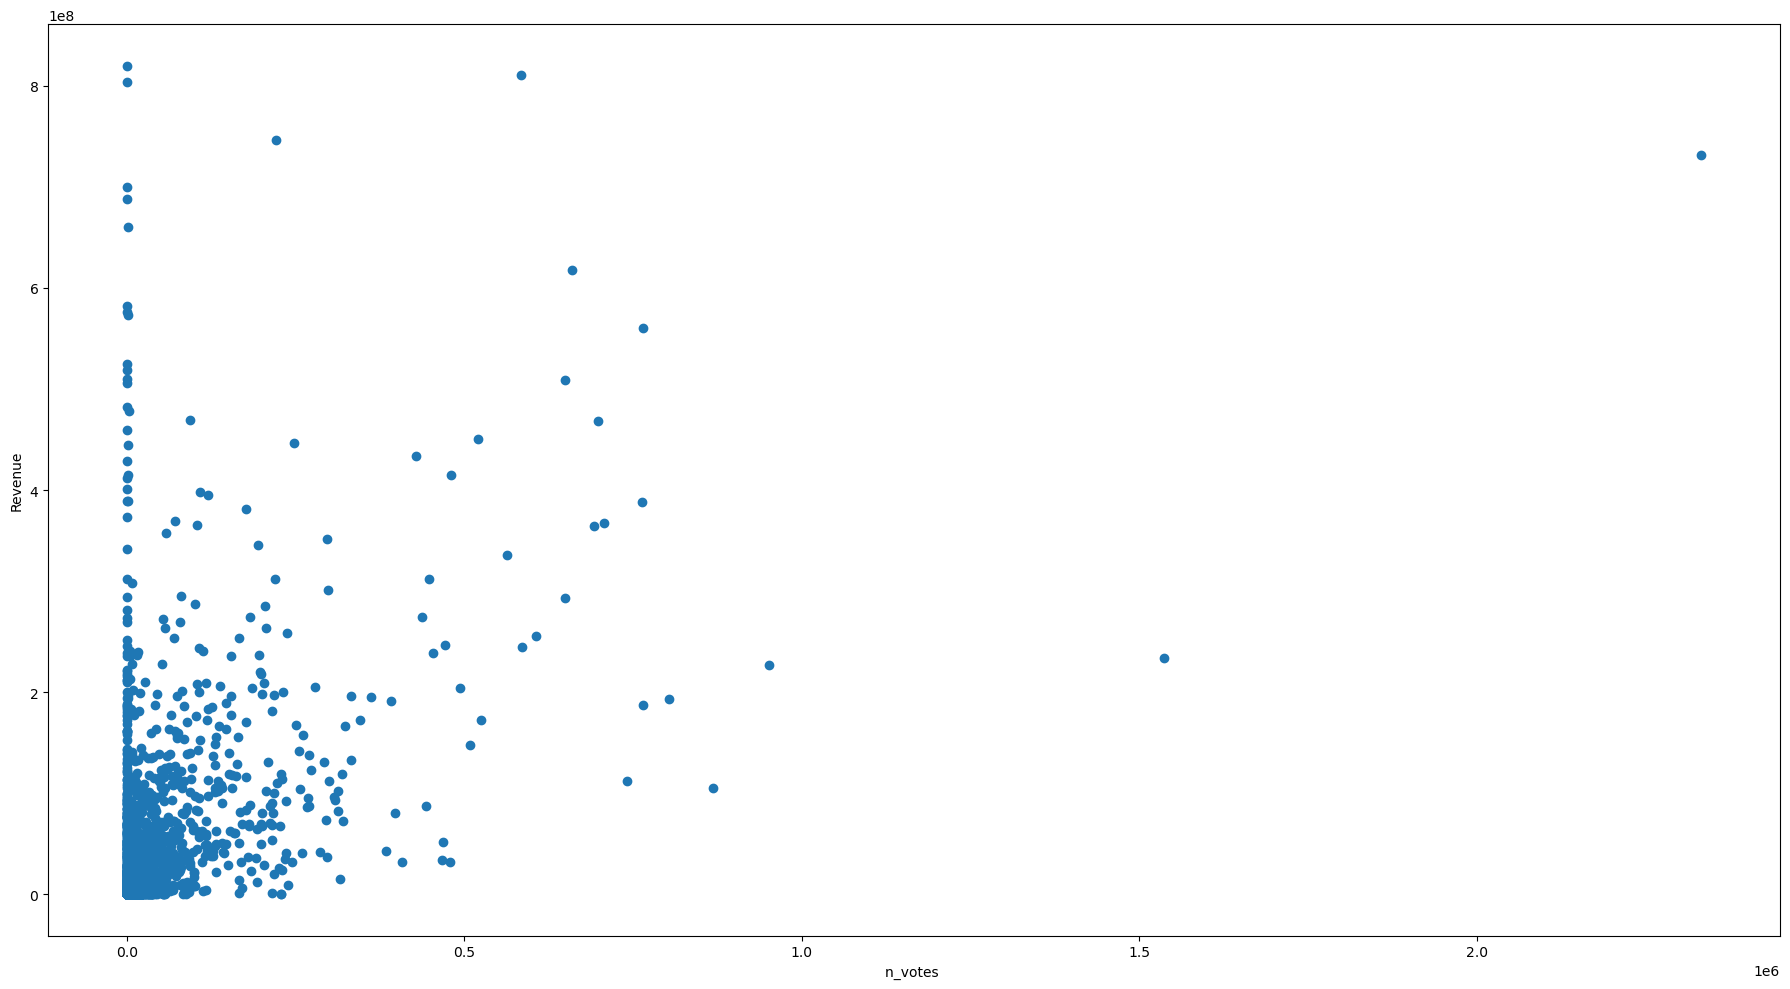

In [7]:
#We will just delete n_votes' outliers cause is one of the most important features related with Revenue of a film.

# Scatter plot
fig, ax = plt.subplots(figsize = (18,10))
ax.scatter(X1_aux['n_votes'], X1_aux['Revenue'])
 
# x-axis label
ax.set_xlabel('n_votes ')
 
# y-axis label
ax.set_ylabel('Revenue')
fig.tight_layout()
plt.show()

In [8]:
upper = np.where(X1_aux['n_votes'] >= 0.5*10**6)
X1_aux.drop(upper[0], inplace = True)
Y1.insert(1,'n_votes',X1_aux['n_votes']) #We also delete the outliers from the Y1
Y1.drop(upper[0], inplace = True)
Y1 = Y1.drop('n_votes', axis=1)

In [9]:
X1_aux

,Revenue,ratings,n_votes,production_year,runtime,release_year,Musical,Family,Thriller,Fantasy,...,pca_img_comp_396,pca_img_comp_397,pca_img_comp_398,pca_img_comp_399,pca_img_comp_400,pca_img_comp_401,pca_img_comp_402,pca_img_comp_403,pca_img_comp_404,pca_img_comp_405
0,7.158530e+07,6.5,92937.0,2010,105.000000,2010.0,0,0,0,0,...,0.774923,0.858045,0.009402,0.783606,-0.489283,0.206411,0.860333,-1.209689,0.483671,-0.583462
1,8.964834e+04,7.9,11.0,1996,92.293346,2014.0,0,0,0,0,...,0.349620,-0.196031,0.170030,0.376267,0.302153,-0.412912,0.042465,0.310031,0.658467,-0.807467
2,3.164907e+07,5.9,1345.0,1978,127.000000,1978.0,0,1,0,0,...,0.252135,0.051669,-0.021510,-0.353405,-0.300573,-0.235585,0.077417,0.320302,0.415902,0.401009
3,3.898197e+07,6.6,4851.0,1994,105.000000,1994.0,0,0,0,0,...,-1.088716,-0.771210,-0.295492,-0.333292,-0.524028,0.024912,0.100070,-0.271963,-0.115093,0.586810
4,9.697023e+06,4.1,549.0,1982,108.000000,1982.0,0,0,0,0,...,-0.419060,0.272803,-0.068955,0.849252,-0.263913,-0.342559,-0.218796,-0.344628,-0.240223,0.239812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,1.280834e+05,6.3,973.0,1997,94.000000,1999.0,0,0,0,0,...,-0.147063,0.084205,0.727378,-0.373030,0.566965,0.040015,0.253777,0.247445,0.706011,-0.008587
3536,5.620866e+04,8.0,2190.0,1961,25.000000,2017.0,0,0,0,1,...,-0.099593,-0.843445,0.497908,-0.012698,0.487155,0.214078,-0.318832,0.242757,-0.017408,-0.515621
3537,2.677043e+06,7.6,34.0,2001,44.000000,2000.0,0,0,0,0,...,-0.043195,-0.011906,-0.434667,0.438825,-0.135859,0.242864,0.170630,0.473105,-0.500240,-0.295948
3538,4.480911e+05,7.5,27379.0,2006,98.000000,2006.0,0,0,0,0,...,-0.013072,0.449337,0.544478,0.247291,0.459325,0.116061,-0.299735,-0.909794,0.371700,-0.731538


In [10]:
Y1

,revenue
0,7.158530e+07
1,8.964834e+04
2,3.164907e+07
3,3.898197e+07
4,9.697023e+06
...,...
3535,1.280834e+05
3536,5.620866e+04
3537,2.677043e+06
3538,4.480911e+05


# Split dataframe

In [11]:
#Lets split randomly our dataframe in two part, the train set and the test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1_aux,Y1, test_size=0.2)

# Standarize and Scale

In [12]:
scaler  = RobustScaler()

x_train_scaled = scaler.fit_transform(x_train.to_numpy()) #We fit the scaler with X_train and then transform  both splits with it.
x_train_scaled = pd.DataFrame(x_train_scaled,columns= x_train.columns.values )

x_test_scaled = scaler.transform(x_test.to_numpy())
x_test_scaled = pd.DataFrame(x_test_scaled,columns= x_train.columns.values )

scaler_y = RobustScaler()

y_train_scaled = scaler_y.fit_transform(y_train.to_numpy())
y_train_scaled = pd.DataFrame(y_train_scaled,columns= y_train.columns.values )


In [13]:
x_train_scaled

,Revenue,ratings,n_votes,production_year,runtime,release_year,Musical,Family,Thriller,Fantasy,...,pca_img_comp_396,pca_img_comp_397,pca_img_comp_398,pca_img_comp_399,pca_img_comp_400,pca_img_comp_401,pca_img_comp_402,pca_img_comp_403,pca_img_comp_404,pca_img_comp_405
0,2.095307,0.500000,-0.157973,-1.923077,-3.315789,-1.000000,0.0,0.0,0.0,0.0,...,1.196811,-0.335686,0.502074,0.465738,1.773453,0.177501,-0.776097,0.555307,1.915141,1.255206
1,-0.022162,0.357143,-0.158646,0.000000,-0.947368,0.272727,0.0,0.0,0.0,0.0,...,0.835627,0.087178,1.131240,-1.084594,1.225503,-0.448926,-0.659481,-0.804518,-0.106882,-0.018091
2,-0.022086,-0.357143,-0.063470,0.307692,0.105263,0.272727,0.0,0.0,0.0,0.0,...,-0.344171,0.624098,0.473849,0.879570,-0.360626,-1.533715,-0.266993,0.826753,0.031345,1.169444
3,-0.017523,-0.285714,-0.069867,-0.076923,0.157895,-0.363636,0.0,1.0,1.0,0.0,...,-0.492509,-0.313879,0.151021,-0.570012,-0.657558,-1.337077,-2.228761,-0.861778,-1.161242,0.220823
4,-0.022292,-1.642857,-0.143831,0.153846,0.105263,0.000000,0.0,0.0,0.0,0.0,...,0.804914,-0.499119,-0.189773,2.023337,-1.596446,-0.851676,-0.306962,0.092846,0.127699,0.188310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809,0.196731,-0.500000,0.256629,-0.923077,0.315789,-1.363636,0.0,0.0,0.0,0.0,...,-0.491884,0.353501,-0.861045,0.098115,-0.421880,0.069592,-0.847712,0.229880,0.198060,-0.801435
2810,-0.015525,-0.857143,-0.133730,-0.461538,0.315789,-0.818182,0.0,0.0,0.0,0.0,...,0.427980,-0.281534,0.567578,0.327932,-0.191196,-1.024049,0.439098,-0.690664,-0.697055,-0.034104
2811,0.586944,-0.428571,1.143186,-0.461538,1.315789,-0.818182,0.0,0.0,0.0,0.0,...,-0.553987,-1.016662,-0.303673,1.357335,-0.135259,-0.632910,-1.949380,-0.125485,0.304034,2.281711
2812,0.866004,-0.285714,3.938775,0.307692,0.421053,0.090909,0.0,0.0,0.0,0.0,...,-0.623138,0.091011,-2.299501,-0.471597,1.165739,-0.355377,-0.518926,0.521495,-0.317694,-0.021565


# Features Selection

In [14]:
#Mutual Information method
MI_score = MI(x_train_scaled, y_train_scaled)
sorted_MI= (-MI_score).argsort()
col_names = x_train_scaled.columns[sorted_MI]
rf_MI=col_names[1:50] # We leave out the first element wich is the 'Revenue'

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


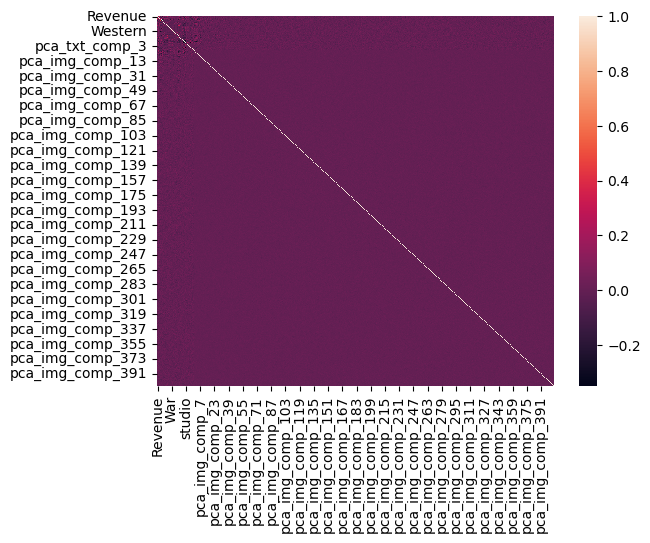

In [15]:
#Correlation metod (Just for linear model)
correlation_matrix = x_train_scaled.corr()
sns.heatmap(correlation_matrix)
relevant_features = correlation_matrix['Revenue'][abs(correlation_matrix['Revenue'])>0.1]
relevant_features = relevant_features.drop('Revenue')
rf_corr = [k for k,v in relevant_features.items() if k != 'Revenue']

In [16]:
relevant_features

n_votes           0.374482
release_year     -0.202511
Family            0.110092
Adventure         0.241398
Short             0.113531
Action            0.190986
Drama            -0.127758
pca_txt_comp_5   -0.129196
pca_img_comp_5   -0.105829
Name: Revenue, dtype: float64

# Extra functions

In [17]:
def compute_rmse(y_t, y_p):
    return mean_squared_error(y_t,y_p)**(0.5)/1000000

In [18]:
def perform_grid_search(model_, hyper_params_grid, score_function, x_train, y_train, rf, cv1 ):
    X_train_filtered = x_train[rf]
    
    scorer = make_scorer(score_function, greater_is_better=False)
    
    grid = GridSearchCV(model_, param_grid=hyper_params_grid, scoring=scorer , cv = cv1,error_score='raise')
    grid.fit(X_train_filtered,y_train)
    
    return grid

# LINEAR MODEL

In [20]:
print('RMSE with Feature Selection')
x_train_filtered = x_train_scaled[rf_corr]  #We filter the train dataset with our relevant features
x_test_filtered = x_test_scaled[rf_corr]   #We filter the test dataset with our relevant features
    
linear_regression_m = LinearRegression()                   #Create the regressor
linear_regression_m.fit(x_train_filtered,y_train_scaled)   #Fit it with the feature selection done 

y_pred = linear_regression_m.predict(x_test_filtered)      #Predict
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)) #Rescale the predicted data
print(compute_rmse(y_pred,y_test))                         #Compute the error 
print(metrics.r2_score(y_test,y_pred))
print(explained_variance_score(y_test,y_pred))

RMSE with Feature Selection
58.30409948081129
0.28609173242653163
0.28610926253014546


# KNN MODEL

In [20]:
k_range =[]
for i in range(100):
    k_range.append(i+1)

param_grid = dict(n_neighbors=k_range)
knn = KNeighborsRegressor()
grid = perform_grid_search(knn, param_grid, compute_rmse, x_train_scaled, y_train_scaled,  rf_MI , cv1 = 5 )
print(grid.best_score_)
print(grid.best_params_)

-2.9778509943961457e-06
{'n_neighbors': 16}


In [21]:
best_model = KNeighborsRegressor(14)
x_train_scaled_filtered = x_train_scaled[rf_MI]
x_test_scaled_filtered = x_test_scaled[rf_MI]

best_model.fit(x_train_scaled_filtered,y_train_scaled)
y_pred = best_model.predict(x_test_scaled_filtered)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)) #We invert the scale in oder to compute the RMSE 

print(compute_rmse(y_pred,y_test))
print(explained_variance_score(y_test,y_pred))
print(metrics.r2_score(y_test,y_pred))

56.86882032682746
0.15643304676350334
0.15252938363106971


# MLP MODEL

In [22]:
#Lets now use GridSearchCV in order to get the best parameters for our MLP regressor. This should take some time to finish
param_grid = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40)], 
    'max_iter': [250], 
    'activation': ['relu'],
    'solver': [ 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
MLP = MLPRegressor()
grid = perform_grid_search(MLP, param_grid, compute_rmse, x_train_scaled ,y_train_scaled, rf_MI,cv1 = 10)
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y 

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y 

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y 

-3.172916579648316e-06
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 250, 'solver': 'adam'}
MLPRegressor(hidden_layer_sizes=(150, 100, 50), learning_rate='adaptive',
             max_iter=250)


In [22]:
#Lets check  MLP model with that hyperparameters (without Feature Selection)
mlp_reg = MLPRegressor(hidden_layer_sizes=(150,100,50),max_iter = 250,activation = 'relu',solver = 'adam',alpha = 0.05, learning_rate = 'adaptive')

x_train_scaled_filtered = x_train_scaled[rf_MI]
x_test_scaled_filtered = x_test_scaled[rf_MI]

mlp_reg.fit(x_train_scaled_filtered, y_train_scaled)

y_pred = mlp_reg.predict(x_test_scaled_filtered)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

print(compute_rmse(y_pred,y_test))
print(explained_variance_score(y_test,y_pred))
print(metrics.r2_score(y_test,y_pred))

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


59.216489903526664
0.0865404331293752
0.08111421785482786


# RANDOM FOREST MODEL

In [24]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}
RFR = RandomForestRegressor()
grid = perform_grid_search(RFR, param_grid, compute_rmse, x_train_scaled ,y_train_scaled, rf_MI,cv1 = 10)
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

-3.1053736865974983e-06
{'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}
RandomForestRegressor(max_depth=90, max_features=3, min_samples_leaf=3,
                      min_samples_split=10, n_estimators=300)


In [23]:
#RFR = RandomForestRegressor(bootstrap=True,max_depth = 110,max_features = 3 ,min_samples_leaf = 3, min_samples_split = 8,n_estimators = 200)
RFR = RandomForestRegressor(bootstrap=True,max_depth = 90,max_features = 3 ,min_samples_leaf = 3, min_samples_split = 10,n_estimators = 300)

x_train_scaled_filtered = x_train_scaled[rf_MI]
x_test_scaled_filtered = x_test_scaled[rf_MI]

RFR.fit(x_train_scaled_filtered, y_train_scaled)

y_pred = RFR.predict(x_test_scaled_filtered)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

print(compute_rmse(y_pred,y_test))
print(explained_variance_score(y_test,y_pred))

C:\Users\vguec\AppData\Local\Temp\ipykernel_12452\946243384.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(x_train_scaled_filtered, y_train_scaled)


54.67979669975184
0.21748476305490771


# SVR MODEL

In [24]:
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']
def getRegressor(ktype):
    if ktype == 0:
        # Polynomial kernal
        return SVR(kernel='poly', degree=8, gamma="auto")
    elif ktype == 1:
        # Radial Basis Function kernal
        return SVR(kernel='rbf', gamma="auto")
    elif ktype == 2:
        # Sigmoid kernal
        return SVR(kernel='sigmoid', gamma="auto")
    elif ktype == 3:
        # Linear kernal
        return SVR(kernel='linear', gamma="auto")

In [25]:
for i in range(4):
    svregressor = getRegressor(i) 
    svregressor.fit(x_train_scaled_filtered, y_train_scaled)
    y_pred = svregressor.predict(x_test_scaled[rf_MI])
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
    
    print("Evaluation:", kernels[i], "kernel")
    print(compute_rmse(y_pred,y_test))
    print(explained_variance_score(y_test,y_pred))

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluation: Polynomial kernel
531365.8902358144
-73639127.00515503


C:\Users\vguec\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluation: RBF kernel
55.664029459450816
0.23364634870760137


C:\Users\vguec\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluation: Sigmoid kernel
1390.5941576246842
-504.88894535392313


C:\Users\vguec\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluation: Linear kernel
56.61653700665266
0.21513233866648573


# MODEL SELECTION

In [26]:
regressors = {
    "Linear": LinearRegression(),
    "KNN": KNeighborsRegressor(14),
    "MLP": MLPRegressor(hidden_layer_sizes=(150,100,50),max_iter = 250,activation = 'relu',solver = 'adam',alpha = 0.05, learning_rate = 'adaptive'),
    "RandomForestRegressor": RandomForestRegressor(bootstrap=True,max_depth = 90,max_features = 3 ,min_samples_leaf = 3, min_samples_split = 10,n_estimators = 300),
}

In [27]:
df_models = pd.DataFrame(columns=['Regressor', 'Execution Time', 'RMSE', 'RMSE_CV','Explained Variance'])

for key in regressors:
    print('*',key)
    start_time = time.time()
    regressor = regressors[key]
    if key == 'Linear':
        x_train_filtered_linear = x_train_scaled[rf_corr]  #¡
        x_test_filtered_linear = x_test_scaled[rf_corr]
    else:
        x_train_scaled_filtered = x_train_scaled[rf_MI]
        x_test_scaled_filtered = x_test_scaled[rf_MI]
        
    model = regressor.fit(x_train_scaled_filtered, y_train_scaled)
    y_pred = model.predict(x_test_scaled_filtered)

    scores = cross_val_score(model, 
                             x_train_scaled_filtered, 
                             y_train,  
                             scoring='neg_mean_squared_error',
                             cv=10)
    scores2= cross_val_score(model, 
                             x_train_scaled_filtered, 
                             y_train,  
                             scoring='explained_variance',
                             cv=10)
    
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
    rmse_mean = np.mean(np.sqrt(-scores))/1000000
    explained_variance_mean = np.mean(scores2)
    row = {'Regressor': key,
           'Execution Time': format(round((time.time() - start_time)/60,2)),
           'RMSE': compute_rmse(y_pred,y_test),
           'RMSE_CV': rmse_mean,
           'Explained Variance': explained_variance_mean,
    }

    df_models = df_models.append(row, ignore_index=True)

* Linear
* KNN


C:\Users\vguec\AppData\Local\Temp\ipykernel_12452\842445318.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Users\vguec\AppData\Local\Temp\ipykernel_12452\842445318.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


* MLP


C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization h

C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rave

* RandomForestRegressor


C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\vguec\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

In [28]:
df_models

,Regressor,Execution Time,RMSE,RMSE_CV,Explained Variance
0,Linear,0.0,53.664055,61.136964,0.178391
1,KNN,0.01,56.868820,59.744804,0.224604
2,MLP,2.16,59.302716,61.012883,0.180418
3,RandomForestRegressor,0.7,54.655994,59.982498,0.216090


In [31]:
#Looking at the dataframe we can conclude that our best model is Random Forest Regressor  . More explaination at the report

In [20]:
RFR = RandomForestRegressor(bootstrap=True,max_depth = 90,max_features = 3 ,min_samples_leaf = 3, min_samples_split = 10,n_estimators = 300)

x_train_scaled_filtered = x_train_scaled[rf_MI]
x_test_scaled_filtered = x_test_scaled[rf_MI]

RFR.fit(x_train_scaled_filtered, y_train_scaled)

y_pred = RFR.predict(x_test_scaled_filtered)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

print(compute_rmse(y_pred,y_test))
print(explained_variance_score(y_test,y_pred))

C:\Users\vguec\AppData\Local\Temp\ipykernel_14224\281729511.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(x_train_scaled_filtered, y_train_scaled)


57.00126116309307
0.18932751816968296


# APPLYING REGRESSOR TO X2

In [21]:
X2 = pd.read_csv('X2.csv')

In [22]:
X2.shape

(1518, 14)

In [23]:
#Obviously to predict the target values with X2 we have to apply it the same preprocessing as we did for X1

In [24]:
#                     DROP FEATURES
#Delete the features which are strings and which does not give much information
X2_aux = X2.drop(['title', 'img_url', 'description'], axis=1) 
#We also have to drop the feature "Unnamed: 0" cause it is not a real feature, is due to the original database of the dataframe
X2_aux = X2_aux.drop('Unnamed: 0', axis=1)
#Also the feature 'is_adult' should be deleted as its unique value is 0.
X2_aux= X2_aux.drop('is_adult',axis=1)


#                    RUNTIME
#Just to reformat the NaN of the "runtime" column and change it by its mean
X2_aux.runtime = X2_aux.runtime.replace({"\\N": np.nan})
X2_aux['runtime']=X2_aux['runtime'].astype('float64')
runtime_Mean=X2_aux['runtime'].mean()
X2_aux.runtime=X2_aux.runtime.replace({np.nan:runtime_Mean})

#                     GENRES
#Now we will split the feature "genres". To do this first we will take all the possible genres and then apply 
# "One hot enconding"
dataframe = X2_aux.genres.str.split(",",expand= True)
lista1 = dataframe[0].unique()
lista2 = dataframe[1].unique()
lista3 = dataframe[2].unique()
lista_aux = np.append(lista1, lista2)
set_genres = set(np.append(lista_aux,lista3))
set_genres.remove(None)
lista_genres = list(set_genres)
for i in range(len(lista_genres)):
    X2_aux.insert(6+i,lista_genres[i],0)

X2_aux = X2_aux.drop('genres', axis=1)

for i in range(1518):
    for j in range(len(lista_genres)):
        for z in range(3):
            if lista_genres[j] == dataframe.iloc[i][z]:
                X2_aux.loc[i,lista_genres[j]] = 1

#                EMBEDDINGS
#We split the feature "img_embeddings"  
df_img = X2_aux.img_embeddings.str[1:-1].str.split(",",expand= True)
col_names=[]
for i in range(len(df_img.columns)):
    col_names = col_names + [f'img_{i}']
df_img.columns=col_names
df_img = df_img.astype('float64')

#We do the same with the feature "text_embeddings"
df_txt = X2_aux.text_embeddings.str[1:-1].str.split(",",expand= True)
col_names=[]
for i in range(len(df_txt.columns)):
    col_names = col_names + [f'txt_{i}']
df_txt.columns=col_names
df_txt = df_txt.astype('float64')


#               STUDIO
#Transform Categorical feature "studio" into numerical feature
le = preprocessing.LabelEncoder()
le.fit(X2_aux["studio"])
X2_aux["studio"] = le.transform(X2_aux["studio"])

X2_aux = X2_aux.drop('\\N', axis=1)

In [25]:
X2_aux

,ratings,n_votes,production_year,runtime,release_year,Musical,Family,Thriller,Fantasy,Sci-Fi,...,Reality-TV,Action,Horror,Biography,Drama,Comedy,Documentary,studio,img_embeddings,text_embeddings
0,7.5,24256.0,2003,106.0,2003.0,0,0,0,0,0,...,0,0,0,0,1,0,0,235,"[0.2698399, 3.1845033, 0.13669977, 0.14299123,...","[-0.62699246, 0.3949766, 0.9997058, -0.9845231..."
1,5.9,48.0,1964,11.0,2017.0,0,0,0,0,0,...,0,0,0,0,0,0,0,291,"[0.4279979, 0.82890534, 1.0090543, 0.17800629,...","[-0.78522605, 0.46340582, 0.9999196, -0.991904..."
2,6.3,6.0,1957,30.0,2009.0,0,0,0,0,0,...,0,0,0,0,1,0,0,87,"[0.3227182, 4.6717577, 0.24727274, 0.30942556,...","[-0.51733744, 0.3527469, 0.9993828, -0.9729327..."
3,7.9,80.0,1972,60.0,2004.0,0,0,0,0,0,...,0,0,0,0,0,0,0,36,"[0.011863205, 1.0377717, 0.6964849, 0.27411973...","[-0.52853703, 0.24114524, 0.998973, -0.9659761..."
4,5.8,1359.0,1994,105.0,1994.0,0,0,0,0,0,...,0,0,0,1,0,0,0,272,"[0.18395236, 2.0983813, 0.29292667, 0.59968936...","[-0.6487137, 0.4033376, 0.999519, -0.97546834,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,5.2,503.0,1987,86.0,1988.0,0,0,0,0,0,...,0,0,0,0,0,1,0,270,"[0.6907283, 1.729979, 0.55596817, 0.27663177, ...","[-0.7183374, 0.38522938, 0.9998054, -0.9850116..."
1514,8.2,12.0,1967,60.0,2016.0,0,0,0,0,0,...,0,0,0,0,1,0,0,292,"[0.032674238, 1.3305097, 0.5538778, 0.22841696...","[-0.48803085, 0.2479086, 0.99892545, -0.969775..."
1515,6.5,8496.0,1999,96.0,1999.0,0,0,0,0,0,...,0,0,0,0,1,1,0,168,"[0.5881883, 2.1023622, 0.56811166, 0.4214271, ...","[-0.60516053, 0.32674095, 0.9993118, -0.975308..."
1516,6.6,78189.0,2000,116.0,2000.0,0,0,0,0,0,...,0,1,0,0,0,0,0,280,"[0.6784923, 3.2537642, 0.07126416, 0.4950616, ...","[-0.6654562, 0.32529247, 0.9996618, -0.9790677..."


Shape of txt componentes before PCA:  (1518, 768)
Shape of txt componentes after PCA:  (1518, 6)
Shape of img  componentes before PCA:  (1518, 2048)
Shape of img componentes after PCA:  (1518, 334)


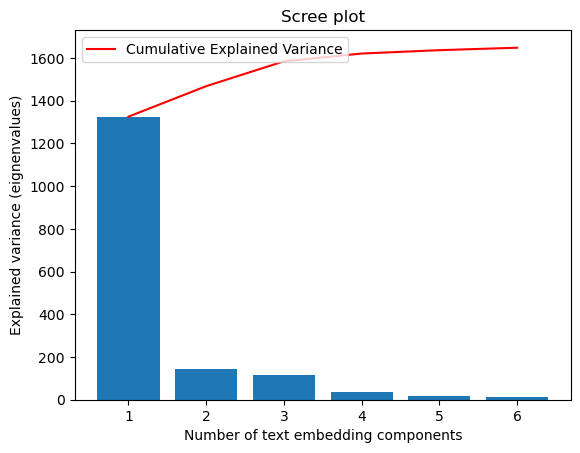

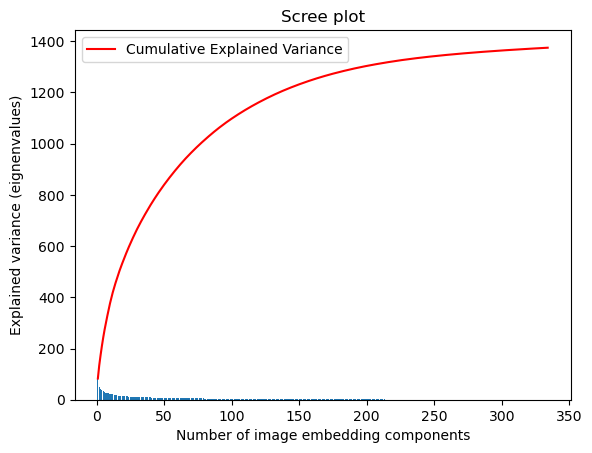

In [26]:
#PCA is effected by scale so you need to scale the features in the data before applying PCA
txt_scaler  = RobustScaler()

img_scaler = RobustScaler()

df_txt_scaled = txt_scaler.fit_transform(df_txt.to_numpy())
df_txt_scaled = pd.DataFrame(df_txt_scaled,columns= df_txt.columns.values )

df_img_scaled = img_scaler.fit_transform(df_img.to_numpy())
df_img_scaled = pd.DataFrame(df_img_scaled,columns= df_img.columns.values )

pca_txt = PCA(0.95)
pca_img = PCA(0.95)

reduced_features_txt = pca_txt.fit_transform(df_txt_scaled)
reduced_features_img = pca_img.fit_transform(df_img_scaled)

print('Shape of txt componentes before PCA: ', df_txt.shape)
print('Shape of txt componentes after PCA: ', reduced_features_txt.shape)  

print('Shape of img  componentes before PCA: ', df_img.shape)
print('Shape of img componentes after PCA: ', reduced_features_img.shape)  


plt.bar(
    range(1,len(pca_txt.explained_variance_)+1),
    pca_txt.explained_variance_
    )
 
plt.plot(
    range(1,len(pca_txt.explained_variance_ )+1),
    np.cumsum(pca_txt.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of text embedding components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')
 
plt.show()

plt.bar(
    range(1,len(pca_img.explained_variance_)+1),
    pca_img.explained_variance_
    )
 
plt.plot(
    range(1,len(pca_img.explained_variance_ )+1),
    np.cumsum(pca_img.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of image embedding components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')

plt.show()


#We compute a dataframe with the reduced features and concatenate them to the X1_aux
pca_txt_columns = []
pca_img_columns =[]
pca_txt_columns = pca_txt_columns + ['pca_txt_comp_%i' % i for i in range(reduced_features_txt.shape[1])]
pca_img_columns = pca_img_columns + ['pca_img_comp_%i' % i for i in range(reduced_features_img.shape[1])]


df_txt_pca = pd.DataFrame(reduced_features_txt, columns = pca_txt_columns)
df_img_pca = pd.DataFrame(reduced_features_img, columns = pca_img_columns)

X2_aux = pd.concat([X2_aux, df_txt_pca], axis=1)
X2_aux = pd.concat([X2_aux, df_img_pca], axis=1)
X2_aux = X2_aux.drop(['text_embeddings', 'img_embeddings'], axis=1)


# Standarize and Scale

scaler  = RobustScaler()

X2_scaled = scaler.fit_transform(X2_aux.to_numpy()) #We fit the scaler with X_train and then transform  both splits with it.
X2_scaled = pd.DataFrame(X2_scaled,columns= X2_aux.columns.values )


In [27]:
X2_scaled

,ratings,n_votes,production_year,runtime,release_year,Musical,Family,Thriller,Fantasy,Sci-Fi,...,pca_img_comp_324,pca_img_comp_325,pca_img_comp_326,pca_img_comp_327,pca_img_comp_328,pca_img_comp_329,pca_img_comp_330,pca_img_comp_331,pca_img_comp_332,pca_img_comp_333
0,0.714286,2.710180,0.214286,0.65,-0.090909,0.0,0.0,0.0,0.0,0.0,...,-1.056512,0.765317,-0.245125,-1.400605,-1.446298,1.129400,-0.073258,1.734246,-0.103130,0.152940
1,-0.428571,-0.138071,-2.571429,-4.10,1.181818,0.0,0.0,0.0,0.0,0.0,...,1.020797,-0.938080,-1.725463,1.511856,-1.265254,1.045657,-0.509063,-1.703200,0.254029,1.332272
2,-0.142857,-0.143013,-3.071429,-3.15,0.454545,0.0,0.0,0.0,0.0,0.0,...,-1.669256,0.289086,-0.095711,0.265989,0.121905,1.336685,-0.996873,0.311081,0.084270,2.074107
3,1.000000,-0.134306,-2.000000,-1.65,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.825029,0.459494,0.661344,-0.698583,-0.710950,0.067483,-0.794497,-0.239845,-0.367576,0.056304
4,-0.500000,0.016178,-0.428571,0.60,-0.909091,0.0,0.0,0.0,0.0,0.0,...,-1.406112,-0.541783,-0.598780,-0.457033,-1.083564,-1.668571,0.170531,0.362513,-0.371151,-0.812339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,-0.928571,-0.084537,-0.928571,-0.35,-1.454545,0.0,0.0,0.0,0.0,0.0,...,-0.255065,0.475516,-1.386370,-1.175167,0.822101,-0.441653,-0.249002,0.324611,-0.511803,-0.054067
1514,1.214286,-0.142307,-2.357143,-1.65,1.090909,0.0,0.0,0.0,0.0,0.0,...,0.150210,0.067189,-0.112039,0.032404,-0.486172,0.607214,-0.254261,0.791739,1.314872,0.653304
1515,0.000000,0.855899,-0.071429,0.15,-0.454545,0.0,0.0,0.0,0.0,0.0,...,0.529125,-0.827032,1.316685,1.039482,0.395292,-0.210117,0.027830,-0.008634,-0.121540,-0.087079
1516,0.071429,9.055799,0.000000,1.15,-0.363636,0.0,0.0,0.0,0.0,0.0,...,1.657956,0.846818,1.765886,0.272431,0.745702,-0.192051,-0.599993,-0.057752,-0.374441,0.978921


Shape of txt componentes before PCA:  (3540, 768)
Shape of txt componentes after PCA:  (3540, 8)
Shape of img  componentes before PCA:  (3540, 2048)
Shape of img componentes after PCA:  (3540, 406)


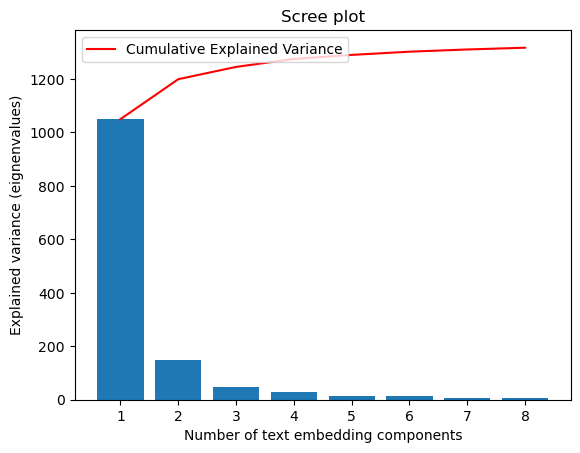

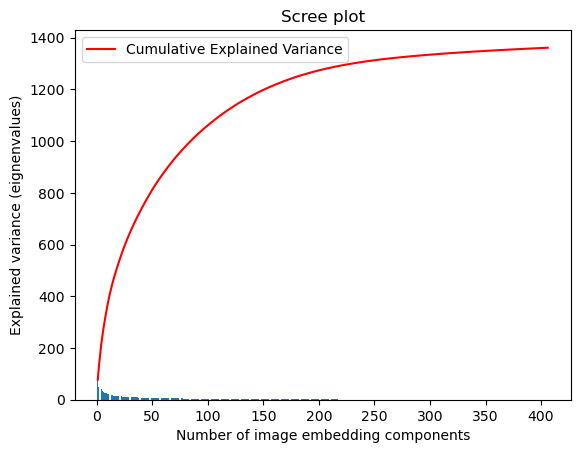

In [28]:
# Use pandas t o l o a d i n t o a DataFrame
# Y1 . c s v doesn ’ t have a he ade r s o
# add one when l o a di n g the f i l e
X1 = pd.read_csv('X1.csv')

#                     DROP FEATURES
#Delete the features which are strings and which does not give much information
X1_aux = X1.drop(['title', 'img_url', 'description'], axis=1) 
#We also have to drop the feature "Unnamed: 0" cause it is not a real feature, is due to the original database of the dataframe
X1_aux = X1_aux.drop('Unnamed: 0', axis=1)
#Also the feature 'is_adult' should be deleted as its unique value is 0.
X1_aux=X1_aux.drop('is_adult',axis=1)


#                    RUNTIME
#Just to reformat the NaN of the "runtime" column and change it by its mean
X1_aux.runtime = X1_aux.runtime.replace({"\\N": np.nan})
X1_aux['runtime']=X1_aux['runtime'].astype('float64')
runtime_Mean=X1_aux['runtime'].mean()
X1_aux.runtime=X1_aux.runtime.replace({np.nan:runtime_Mean})

#                     GENRES
#Now we will split the feature "genres". To do this first we will take all the possible genres and then apply 
# "One hot enconding"
dataframe = X1_aux.genres.str.split(",",expand= True)
lista1 = dataframe[0].unique()
lista2 = dataframe[1].unique()
lista3 = dataframe[2].unique()
lista_aux = np.append(lista1, lista2)
set_genres = set(np.append(lista_aux,lista3))
set_genres.remove(None)
lista_genres = list(set_genres)
for i in range(len(lista_genres)):
    X1_aux.insert(6+i,lista_genres[i],0)

X1_aux = X1_aux.drop('genres', axis=1)

for i in range(3540):
    for j in range(len(lista_genres)):
        for z in range(3):
            if lista_genres[j] == dataframe.iloc[i][z]:
                X1_aux.loc[i,lista_genres[j]] = 1

#                EMBEDDINGS
#We split the feature "img_embeddings"  
df_img = X1_aux.img_embeddings.str[1:-1].str.split(",",expand= True)
col_names=[]
for i in range(len(df_img.columns)):
    col_names = col_names + [f'img_{i}']
df_img.columns=col_names
df_img = df_img.astype('float64')

#We do the same with the feature "text_embeddings"
df_txt = X1_aux.text_embeddings.str[1:-1].str.split(",",expand= True)
col_names=[]
for i in range(len(df_txt.columns)):
    col_names = col_names + [f'txt_{i}']
df_txt.columns=col_names
df_txt = df_txt.astype('float64')


#               STUDIO
#Transform Categorical feature "studio" into numerical feature
le = preprocessing.LabelEncoder()
le.fit(X1_aux["studio"])
X1_aux["studio"] = le.transform(X1_aux["studio"])

X1_aux = X1_aux.drop('\\N', axis=1)

#PCA is effected by scale so you need to scale the features in the data before applying PCA
txt_scaler  = RobustScaler()

img_scaler = RobustScaler()

df_txt_scaled = txt_scaler.fit_transform(df_txt.to_numpy())
df_txt_scaled = pd.DataFrame(df_txt_scaled,columns= df_txt.columns.values )

df_img_scaled = img_scaler.fit_transform(df_img.to_numpy())
df_img_scaled = pd.DataFrame(df_img_scaled,columns= df_img.columns.values )

pca_txt = PCA(0.95)
pca_img = PCA(0.95)

reduced_features_txt = pca_txt.fit_transform(df_txt_scaled)
reduced_features_img = pca_img.fit_transform(df_img_scaled)

print('Shape of txt componentes before PCA: ', df_txt.shape)
print('Shape of txt componentes after PCA: ', reduced_features_txt.shape)  

print('Shape of img  componentes before PCA: ', df_img.shape)
print('Shape of img componentes after PCA: ', reduced_features_img.shape)  


plt.bar(
    range(1,len(pca_txt.explained_variance_)+1),
    pca_txt.explained_variance_
    )
 
plt.plot(
    range(1,len(pca_txt.explained_variance_ )+1),
    np.cumsum(pca_txt.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of text embedding components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')
 
plt.show()

plt.bar(
    range(1,len(pca_img.explained_variance_)+1),
    pca_img.explained_variance_
    )
 
plt.plot(
    range(1,len(pca_img.explained_variance_ )+1),
    np.cumsum(pca_img.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of image embedding components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')

plt.show()
#We compute a dataframe with the reduced features and concatenate them to the X1_aux
pca_txt_columns = []
pca_img_columns =[]
pca_txt_columns = pca_txt_columns + ['pca_txt_comp_%i' % i for i in range(reduced_features_txt.shape[1])]
pca_img_columns = pca_img_columns + ['pca_img_comp_%i' % i for i in range(reduced_features_img.shape[1])]


df_txt_pca = pd.DataFrame(reduced_features_txt, columns = pca_txt_columns)
df_img_pca = pd.DataFrame(reduced_features_img, columns = pca_img_columns)

X1_aux = pd.concat([X1_aux, df_txt_pca], axis=1)
X1_aux = pd.concat([X1_aux, df_img_pca], axis=1)
X1_aux = X1_aux.drop(['text_embeddings', 'img_embeddings'], axis=1)
#We will just delete n_votes' outliers cause is one of the most important features related with Revenue of a film.


upper = np.where(X1_aux['n_votes'] >= 0.5*10**6)
X1_aux.drop(upper[0], inplace = True)

scaler  = RobustScaler()
x_train_scaled = scaler.fit_transform(X1_aux.to_numpy()) #We fit the scaler with X_train and then transform  both splits with it.
x_train_scaled = pd.DataFrame(x_train_scaled,columns= X1_aux.columns.values )






In [29]:
x_train_scaled

,ratings,n_votes,production_year,runtime,release_year,Musical,Family,Thriller,Fantasy,Sci-Fi,...,pca_img_comp_396,pca_img_comp_397,pca_img_comp_398,pca_img_comp_399,pca_img_comp_400,pca_img_comp_401,pca_img_comp_402,pca_img_comp_403,pca_img_comp_404,pca_img_comp_405
0,0.000000,10.286942,0.769231,0.631579,0.636364,0.0,0.0,0.0,0.0,0.0,...,1.362100,1.503788,0.045772,1.365883,-0.823531,0.368357,1.490013,-2.102180,0.870033,-0.956273
1,0.933333,-0.155355,-0.307692,-0.037192,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.620197,-0.325781,0.330758,0.656413,0.526510,-0.733342,0.072971,0.517110,1.180925,-1.333653
2,-0.400000,-0.005450,-1.692308,1.789474,-2.272727,0.0,1.0,0.0,0.0,0.0,...,0.450144,0.104154,-0.009074,-0.614466,-0.501626,-0.417899,0.133529,0.534812,0.749498,0.702261
3,0.066667,0.388527,-0.461538,0.631579,-0.818182,0.0,0.0,0.0,0.0,0.0,...,-1.888848,-1.324123,-0.495172,-0.579435,-0.882799,0.045494,0.172778,-0.485977,-0.194931,1.015280
4,-1.600000,-0.094898,-1.384615,0.789474,-1.909091,0.0,0.0,0.0,0.0,0.0,...,-0.720694,0.487979,-0.093250,1.480219,-0.439092,-0.608193,-0.379691,-0.611217,-0.417488,0.430694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3513,-0.133333,-0.047253,-0.230769,0.052632,-0.363636,0.0,0.0,0.0,0.0,0.0,...,-0.246220,0.160627,1.319607,-0.648648,0.978231,0.072360,0.439092,0.409240,1.265487,0.012216
3514,1.000000,0.089504,-3.000000,-3.578947,1.272727,0.0,0.0,0.0,1.0,0.0,...,-0.163413,-1.449503,0.912479,-0.021052,0.842090,0.381996,-0.553014,0.401161,-0.021189,-0.841982
3515,0.733333,-0.152770,0.076923,-2.578947,-0.272727,0.0,0.0,0.0,0.0,0.0,...,-0.065033,-0.006193,-0.742097,0.765373,-0.220655,0.433204,0.295030,0.798173,-0.879955,-0.471899
3516,0.666667,2.920047,0.461538,0.263158,0.272727,0.0,0.0,0.0,0.0,0.0,...,-0.012486,0.794390,0.995104,0.431775,0.794618,0.207637,-0.519926,-1.585300,0.670881,-1.205736


In [30]:
Y1 = pd.read_csv('Y1.csv', header=None , names =['revenue'])
Y1.insert(1,'n_votes',X1_aux['n_votes']) #We also delete the outliers from the Y1
Y1.drop(upper[0], inplace = True)
Y1 = Y1.drop('n_votes', axis=1)

scaler_y = RobustScaler()

y_train_scaled = scaler_y.fit_transform(Y1.to_numpy())
y_train_scaled = pd.DataFrame(y_train_scaled,columns= Y1.columns.values )

In [31]:
y_train_scaled

,revenue
0,3.522576
1,-0.019400
2,1.544090
3,1.907370
4,0.456560
...,...
3513,-0.017496
3514,-0.021057
3515,0.108782
3516,-0.001643


In [33]:
columnsX2 = X2_scaled.columns

In [34]:
rf = []
for i in range(len(rf_MI)):
    if rf_MI[i] in columnsX2:
        rf.append(rf_MI[i])
    

In [36]:
RFR = RandomForestRegressor(bootstrap=True,max_depth = 90,max_features = 3 ,min_samples_leaf = 3, min_samples_split = 10,n_estimators = 300)

x_train_scaled_filtered = x_train_scaled[rf]

RFR.fit(x_train_scaled_filtered, y_train_scaled)

y_pred = RFR.predict(X2_scaled[rf])
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

C:\Users\vguec\AppData\Local\Temp\ipykernel_18148\2942002499.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFR.fit(x_train_scaled_filtered, y_train_scaled)


In [37]:
y_pred

array([[27807825.24191311],
       [46025440.48065985],
       [42878779.02178991],
       ...,
       [13552405.3958591 ],
       [66490822.24425471],
       [22613284.22959991]])

In [41]:
y_pred = np.append(y_pred,59982498)

In [42]:
Y2 = pd.DataFrame(y_pred)

In [43]:
Y2

,0
0,2.780783e+07
1,4.602544e+07
2,4.287878e+07
3,1.192917e+07
4,3.589603e+07
...,...
1514,2.460097e+07
1515,1.355241e+07
1516,6.649082e+07
1517,2.261328e+07


In [45]:
Y2.to_csv('Y2.csv',header=False, index=False)